In [1]:
import hifive
import matplotlib.pyplot as plt
import numpy as np
import pybedtools as bed

In [6]:
hic=hifive.HiC('/Users/cmdb/qbb2020-answers/week11/genome/project.hic', 'r')
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)
data +=1
enrichment = data[:,:,0]/data[:,:,1]
log_trans = np.log(enrichment)

Finding fend full array for chr13:1000000-120250001... Done


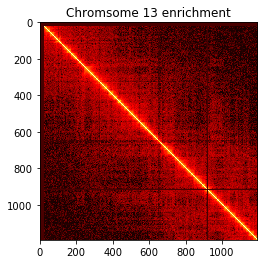

In [7]:
plt.imshow(log_trans, cmap='hot', interpolation='nearest')
plt.title('Chromsome 13 enrichment')
plt.show()

In [8]:
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Finding expected full array for chr13:3000000-120300000... Done
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arr

In [9]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']

In [55]:
gene_data = open('./data/WT_fpkm.bed', 'r')
genes = {}
for line in gene_data:
    if 'chr13' not in line:
        continue
    else:
        lines = line.split('\t')
        name = lines[3]
        start = int(lines[1])
        end = int(lines[2])
        FPKM = float(lines[4])
        genes.setdefault(name, [start, end, FPKM])
print(genes)

{'Gm17750': [84164902, 84204379, 0.0], 'Tpbpb': [61002656, 61006208, 0.0], 'Nsa2': [97899382, 97907881, 164.765036531], 'Rnf44': [54780760, 54795321, 96.2888655842], 'Arhgef28': [98668550, 98976120, 6.86887351155], 'Tpbpa': [61039853, 61043297, 0.0], 'Pelo': [115878563, 115880366, 23.1716048966], 'Olfr1359': [21794843, 21795834, 0.0], '4930526H09Rik': [111672619, 111694054, 0.0], 'Gm26688': [40823177, 40830531, 0.0210726094943], 'A330076C08Rik': [44288958, 44311856, 0.0], 'Mir692-3': [74544513, 74544621, 0.0], 'Ccnh': [85328990, 85353336, 57.1144849036], 'Grk6': [55546433, 55562288, 64.7089729369], 'Gcm2': [41196796, 41205357, 0.0114768501866], 'Col4a3bp': [97312690, 97410122, 27.7591017027], 'Gm5141': [62873560, 62887168, 5.57486046319], 'Nrsn1': [25343908, 25361865, 6.08632777082], 'Hnrnpa0': [58227240, 58229917, 166.85214753], 'Mier3': [112476386, 112508802, 13.5391210997], '4930555G21Rik': [53743954, 53745450, 0.0], 'Rnf180': [105937574, 106083094, 0.544044824368], 'Rnf182': [43711

In [22]:
hic_data = open('./hic_comp.bed', 'r')
hic_value = []
for line in hic_data:
    lines = line.rstrip().split('\t')
    start = int(lines[1])
    end = int(lines[2])
    value = float(lines[3])
    int_list = [start, end, value]
    hic_value.append(int_list)

In [23]:
print(hic_value)

[[3000000, 3100000, -0.005205], [3100000, 3200000, -0.004578], [3200000, 3300000, 0.000617], [3300000, 3400000, 0.005744], [3400000, 3500000, 0.017047], [3500000, 3600000, 0.02855], [3600000, 3700000, 0.021227], [3700000, 3800000, 0.014095], [3800000, 3900000, 0.019423], [3900000, 4000000, 0.011376], [4000000, 4100000, -0.000716], [4100000, 4200000, -0.001675], [4200000, 4300000, 0.000928], [4300000, 4400000, -0.009331], [4400000, 4500000, -0.017516], [4500000, 4600000, -0.017383], [4600000, 4700000, -0.012338], [4700000, 4800000, -0.010438], [4800000, 4900000, -0.016438], [4900000, 5000000, -0.02632], [5000000, 5100000, -0.03043], [5100000, 5200000, -0.027394], [5200000, 5300000, -0.027019], [5300000, 5400000, -0.020319], [5400000, 5500000, -0.012197], [5500000, 5600000, 0.001694], [5600000, 5700000, 0.008079], [5700000, 5800000, 0.010861], [5800000, 5900000, 0.012914], [5900000, 6000000, -0.000591], [6000000, 6100000, -0.010094], [6100000, 6200000, -0.017364], [6200000, 6300000, -0.0

In [62]:
gene_values = {}
for key, value in genes.items():
    for int_list in hic_value:
        if int_list[0] <= value[1] and int_list[1] >= value[0]:
            if key not in gene_values.keys():
                gene_values.setdefault(key, [int_list[2]])
            else:
                gene_values[key].append(int_list[2])
        elif int_list[1] >= value[0] and value[1] >= int_list[0]:
            if key not in gene_values.keys():
                gene_values.setdefault(key, [int_list[2]])
            else:
                gene_values[key].append(int_list[2])
        else:
            continue

In [64]:
print(gene_values)

{'Gm17750': [-0.036547, -0.037045], 'Ctla2a': [-0.036506], 'Nsa2': [0.047704, 0.047454], 'Rnf44': [0.050656], 'Ctla2b': [-0.02854], 'Pelo': [-0.033947], 'Olfr1359': [0.034448], '4930526H09Rik': [-0.037686], 'Gm26688': [0.022415], 'A330076C08Rik': [0.034012, 0.031287], 'Ccno': [0.042217], 'Ccnh': [-0.022641], 'Mblac2': [0.013416], 'Mir1904': [0.003185], 'Gcm2': [0.035932, 0.032966], 'Col4a3bp': [0.040367, 0.044037], 'Gm5141': [0.028356], 'Nrsn1': [-0.019455], 'Hnrnpa0': [0.048354], 'Mier3': [0.017474, 0.027711], '4930555G21Rik': [0.022887], 'Rnf180': [-0.036118, -0.031683], 'Rnf182': [0.040345], 'Klf6': [0.012914], 'Gpx5': [0.041816], 'Gpx6': [0.0424], 'Homer1': [0.009396, 0.009796], 'Gpx8': [0.027688], 'Ptdss1': [0.034748], 'Amph': [0.005285, -0.001027, 0.000974], 'Gprin1': [0.052814], '2610307P16Rik': [-0.032045, -0.029753, -0.02042, -0.005641, 0.000156], 'Mterf3': [0.034748], 'Susd3': [0.038822], 'Faf2': [0.050656], 'Spata31d1a': [0.045545], 'Mrs2': [0.022815, 0.000475], 'Gmds': [-0.

In [65]:
positive = []
negative = []
for key, value in gene_values.items():
    neg_count = 0
    pos_count = 0
    for i in range(0, len(value)):
        if value[i] < 0:
            neg_count+=1
        elif value[i] > 0:
            pos_count+=1
    if pos_count > neg_count:
        positive.append(key)
    else:
        negative.append(key)

In [66]:
print(positive)

['Nsa2', 'Rnf44', 'Olfr1359', 'Gm26688', 'A330076C08Rik', 'Ccno', 'Mblac2', 'Mir1904', 'Gcm2', 'Col4a3bp', 'Gm5141', 'Hnrnpa0', 'Mier3', '4930555G21Rik', 'Rnf182', 'Klf6', 'Gpx5', 'Gpx6', 'Homer1', 'Gpx8', 'Ptdss1', 'Amph', 'Gprin1', 'Mterf3', 'Susd3', 'Faf2', 'Spata31d1a', 'Mrs2', 'Spata31d1d', 'Hmgcr', 'Cdk20', 'Cartpt', 'Aldh5a1', 'Uqcrb', 'Rmi1', 'A430090L17Rik', 'Gm2762', 'Il31ra', 'Higd2a', 'Unc5a', 'Fcho2', 'Eci3', 'Eci2', 'Nid1', 'Mylip', 'Ggps1', 'Pak1ip1', 'Depdc1b', 'Mirlet7a-1', '4931429P17Rik', 'Zfp712', 'Ccnb1', 'Rpp40', '4921509O07Rik', 'Hexb', '9330199G10Rik', 'Dsp', 'Scgn', 'Slc35b3', 'Nxnl2', 'Ercc8', 'Abt1', 'Zswim6', 'Pfn3', '4933417A18Rik', 'Tdp2', 'Fgfr4', 'Ankra2', 'Pxdc1', 'Calm4', 'Calm5', 'B230219D22Rik', 'Map3k1', 'Ptcd2', 'Hist1h2ap', 'A330033J07Rik', 'Cdc20b', 'Fam217a', 'Mxd3', 'Gm3772', 'Mirlet7f-1', 'Cap2', 'Hist1h2an', 'Tmem174', 'Mir6369', 'Zfp65', 'Agtpbp1', 'Mplkip', 'Akr1c12', 'Diras2', 'Slc17a4', 'Auh', 'Mrps36', 'Slc17a1', 'Slc17a2', 'Slc17a3', 'Z

In [67]:
print(negative)

['Gm17750', 'Ctla2a', 'Ctla2b', 'Pelo', '4930526H09Rik', 'Ccnh', 'Nrsn1', 'Rnf180', '2610307P16Rik', 'Gmds', 'Gpr141', 'Vmn1r197', 'Rasa1', '1700019C18Rik', 'Actbl2', 'Prl7a1', 'Prl7a2', 'Prl3d3', 'Vmn1r198', 'Spata9', 'Fam172a', 'Adcy2', 'Mtrr', 'Atp6ap1l', 'Prl2b1', 'Akr1c18', 'Inhba', 'Zcchc9', 'Mir6368', 'Akr1c14', 'Akr1c13', 'Ctsll3', 'Adgrv1', 'A830009L08Rik', 'Tmem161b', 'Serpinb1a', '5930438M14Rik', 'Serpinb1c', 'Serpinb1b', 'Speer6-ps1', 'Serpinb6d', 'Serpinb6e', 'Nr2f1', 'Serpinb6b', 'Serpinb6c', 'Mir682', 'Akr1c6', 'A530046M15Rik', '4933416M06Rik', 'Gm6093', 'Gm904', 'Rab3c', 'Prl3c1', 'Pou5f2', 'Cwc27', 'Serinc5', 'Mylk4', 'Gli3', 'Spata31d1c', 'Mfsd14b', '1700001L19Rik', 'Vmn1r217', 'Vmn1r216', 'Vmn1r215', 'Vmn1r214', 'Vmn1r213', 'Ofcc1', 'Vmn1r218', 'Srek1ip1', 'AW209491', 'Mtx3', 'Dcdc2a', 'Thbs4', 'Gm30551', 'Htr1a', 'Akr1c21', 'Akr1c20', 'Serpinb9', 'Prl', 'Ssbp2', 'Slf1', '1700092E19Rik', 'BC051665', 'Serpinb9g', 'Ell2', 'Gpr150', 'Cdkal1', 'Gm6416', 'Serpinb9c', 'Ser

In [84]:
import math

In [89]:
positive_exp = {}
for element in positive:
    if element in genes.keys():
        values = genes[element]
        exp = values[2]
        exp += 1
        log_trans = math.log(exp, 2)
        positive_exp.setdefault(element, log_trans)
        

In [93]:
print(positive_exp)

{'Nsa2': 7.3729959327809755, 'Rnf44': 6.604202797266452, 'Olfr1359': 0.0, 'Gm26688': 0.03008546135058382, 'A330076C08Rik': 0.0, 'Ccno': 2.7333580357155656, 'Mir1904': 0.0, 'Col4a3bp': 4.845946708449702, 'Gm5141': 2.716960276731942, 'Hnrnpa0': 7.391047185023244, 'Mier3': 3.861868154830648, '4930555G21Rik': 0.0, 'Rnf182': 0.8819843337065472, 'Klf6': 5.580089868304966, 'Gpx5': 0.02897010704224798, 'Gpx6': 1.6936259637111646, 'Homer1': 3.420528005847998, 'Gpx8': 3.5188711830793613, 'Ptdss1': 4.512570708806116, 'Amph': 3.622016618908375, 'Nsun2': 7.652532245845643, 'Mterf3': 5.538526380878983, 'Faf2': 4.976293463589628, 'Spata31d1a': 0.8397051651789961, 'Mrs2': 2.9599409380191415, 'Spata31d1d': 0.17889937539300632, 'Hmgcr': 7.481072828952554, 'Cdk20': 2.420014888362416, 'Cartpt': 0.0, 'AW495222': 0.0, 'Rmi1': 4.609620993126479, 'A430090L17Rik': 0.02462800446733784, 'Gm2762': 0.4816217217925737, 'Il31ra': 0.05009411967284022, 'Higd2a': 6.111166285607948, 'Unc5a': 0.8711624018077838, 'Fcho2':

In [91]:
negative_exp = {}
for element in negative:
    if element in genes.keys():
        values = genes[element]
        exp = values[2]
        exp +=1
        log_trans = math.log(exp, 2)
        negative_exp.setdefault(element, log_trans)

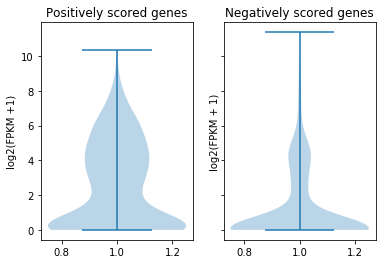

In [99]:
fig, ax = plt.subplots(nrows =1, ncols=2, sharey = True)

ax[0].violinplot(positive_exp.values())
ax[0].set_title('Positively scored genes')
ax[0].set_ylabel('log2(FPKM +1)')
ax[1].violinplot(negative_exp.values())
ax[1].set_title('Negatively scored genes')
ax[1].set_ylabel('log2(FPKM + 1)')
plt.show()